# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import groupby
from pathlib import Path
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.layers import Dense, Reshape
from keras.models import Model
from tqdm import tqdm_notebook as tqdm
import cv2
from tqdm import tqdm, trange
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_train=pd.read_csv("/content/drive/MyDrive/Deep Learning/data/Train.csv")
df_train['Path']=df_train.Path.apply(lambda x: "/content/drive/MyDrive/Deep Learning/data/"+x) ## change and normalize path
df_train['ClassId']=df_train.ClassId.astype(str)

df_test=pd.read_csv("/content/drive/MyDrive/Deep Learning/data/Test.csv")
df_test['Path']=df_test.Path.apply(lambda x: "/content/drive/MyDrive/Deep Learning/data/"+x) ## change and normalize path
df_test['ClassId']=df_test.ClassId.astype(str)

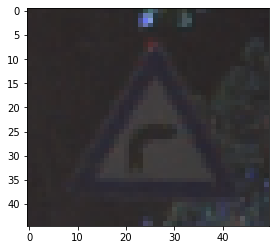

In [4]:
img=cv2.imread(df_train.iloc[18,7])
plt.imshow(img)

In [5]:
train_images=np.load("/content/drive/MyDrive/Deep Learning/raw_train_2.npy")

In [6]:
x_test=np.load("/content/drive/MyDrive/Deep Learning/raw_test_2.npy")

In [7]:
y_train=df_train['ClassId'].astype(int)
y_test=df_test['ClassId'].astype(int)

In [8]:
assert train_images.shape==(39209, 32, 32, 3)
assert x_test.shape==(12630, 32, 32, 3)
assert y_train.shape==(39209,)
assert y_test.shape==(12630,)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(train_images, y_train, test_size=0.2, random_state=42)

In [10]:
y_train=y_train.astype(int)
y_val=y_val.astype(int)

In [11]:
assert x_train.shape==(31367, 32, 32, 3)
assert x_val.shape==(7842,32, 32, 3)
assert y_train.shape==(31367,)
assert y_val.shape==(7842,)

# ResNet50 model

In [12]:
encoder_model = ResNet50(input_shape=(32,32,3), weights='imagenet', include_top=False, pooling='avg')

#Flatten output layer of Resnet
flattened = tf.keras.layers.Flatten()(encoder_model.output)

#Fully connected layer 1
fc1 = tf.keras.layers.Dense(128, activation='relu', name="AddedDense1")(flattened)

#Fully connected layer, output layer
fc2 = tf.keras.layers.Dense(43, activation='softmax', name="AddedDense2")(fc1)

encoder_model = tf.keras.models.Model(inputs=encoder_model.input, outputs=fc2)

94765736/94765736 [==============================] - 0s 0us/step


In [13]:
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [14]:
encoder_model.compile(optimizer=Adam(learning_rate=10e-6),loss='sparse_categorical_crossentropy',metrics='accuracy')

In [15]:
history=encoder_model.fit(x=x_train,y=y_train,batch_size=64,epochs=10,validation_data=(x_val,y_val)) 

Epoch 1/10
491/491 [==============================] - 43s 55ms/step - loss: 3.6455 - accuracy: 0.1403 - val_loss: 2.7414 - val_accuracy: 0.2951
Epoch 2/10
491/491 [==============================] - 23s 48ms/step - loss: 2.2406 - accuracy: 0.4112 - val_loss: 1.7598 - val_accuracy: 0.5300
Epoch 3/10
491/491 [==============================] - 24s 48ms/step - loss: 1.4741 - accuracy: 0.5992 - val_loss: 1.1377 - val_accuracy: 0.6843
Epoch 4/10
491/491 [==============================] - 23s 48ms/step - loss: 0.9702 - accuracy: 0.7278 - val_loss: 0.7494 - val_accuracy: 0.7887
Epoch 5/10
491/491 [==============================] - 23s 48ms/step - loss: 0.6486 - accuracy: 0.8156 - val_loss: 0.4916 - val_accuracy: 0.8583
Epoch 6/10
491/491 [==============================] - 23s 48ms/step - loss: 0.4386 - accuracy: 0.8752 - val_loss: 0.3391 - val_accuracy: 0.9019
Epoch 7/10
491/491 [==============================] - 23s 48ms/step - loss: 0.3014 - accuracy: 0.9148 - val_loss: 0.2427 - val_accuracy:

In [16]:
results = encoder_model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

99/99 [==============================] - 3s 23ms/step - loss: 1.1193 - accuracy: 0.7177
test loss, test acc: [1.119329571723938, 0.7177355289459229]


In [17]:
preds=encoder_model.predict(x_test)

395/395 [==============================] - 6s 12ms/step


In [18]:
pd.DataFrame(abs(preds.argmax(axis=-1)-y_test.astype(int))).value_counts()/12630

ClassId
0          0.717736
1          0.080443
2          0.044656
3          0.044576
4          0.020823
5          0.013381
7          0.011718
6          0.009264
8          0.009264
14         0.006730
10         0.006334
12         0.004830
13         0.003959
11         0.003167
36         0.002850
16         0.002771
9          0.002375
17         0.001584
32         0.001504
26         0.001346
34         0.001029
19         0.000950
15         0.000792
21         0.000792
37         0.000713
30         0.000633
33         0.000633
20         0.000633
31         0.000554
24         0.000475
18         0.000475
28         0.000396
25         0.000396
23         0.000396
22         0.000396
27         0.000317
35         0.000317
38         0.000317
29         0.000238
40         0.000158
41         0.000079
dtype: float64

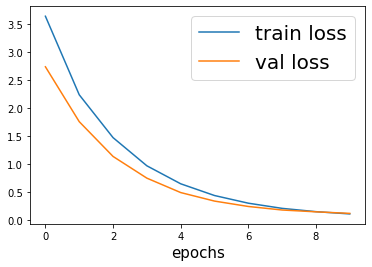

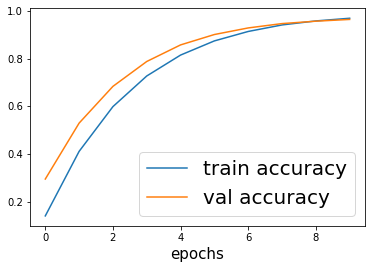

In [19]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

# Dense K-NN model

In [20]:
def build_knn(model, output_size):

    flat_dim_size = np.prod(model.output_shape[1:])
    x = Reshape(target_shape=(flat_dim_size,),
                name='features_flat')(model.output)
    
    x = Dense(units=output_size,
              activation='linear',
              name='dense_1',
              use_bias=False)(x)   
                
    classifier = Model(inputs=[model.input], outputs=x)
    return classifier

joined_model = build_knn(encoder_model, 43)
joined_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [21]:
def normalize_encodings(encodings):
    ref_norms = np.linalg.norm(train_images, axis=0)
    return encodings / ref_norms

In [22]:
encoded_imgs_normalized = normalize_encodings(x_train)

In [24]:
prediction = joined_model.predict(x_test)

395/395 [==============================] - 5s 10ms/step


In [25]:
pd.DataFrame(abs(prediction.argmax(axis=-1)-y_test.astype(int))).value_counts()/len(y_test)

ClassId
7          0.097941
6          0.067696
5          0.066033
1          0.041093
2          0.040618
20         0.039351
15         0.037371
21         0.036105
12         0.035392
29         0.032146
13         0.031512
3          0.030641
26         0.030008
9          0.029770
4          0.029770
30         0.029375
32         0.028741
19         0.028504
17         0.026287
8          0.024545
16         0.022803
27         0.022565
0          0.021378
31         0.020428
24         0.019477
33         0.018765
28         0.017894
22         0.012431
14         0.010293
23         0.009897
18         0.009343
11         0.008472
10         0.006176
25         0.004751
34         0.004671
37         0.003563
36         0.001900
35         0.001267
38         0.000475
41         0.000396
39         0.000079
40         0.000079
dtype: float64

# Classes missclasified :

In [34]:
df_train['ClassId'].unique()

array(['20', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42'], dtype=object)

In [45]:
example_14=cv2.imread(df_train[df_train['ClassId']=='14'].iloc[0,7])

example_17=cv2.imread(df_train[df_train['ClassId']=='17'].iloc[0,7])

example_39=cv2.imread(df_train[df_train['ClassId']=='39'].iloc[0,7])

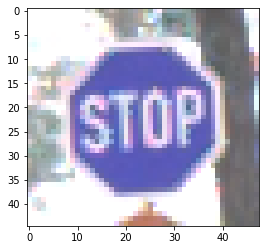

In [44]:
plt.imshow(example_14)

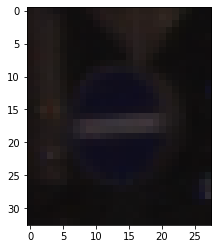

In [46]:
plt.imshow(example_17)

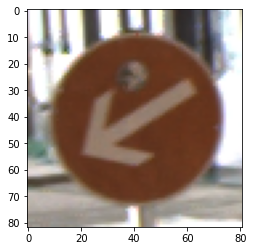

In [47]:
plt.imshow(example_39)

In [52]:
example_0=cv2.imread(df_train[df_train['ClassId']=='0'].iloc[10,7])

example_24=cv2.imread(df_train[df_train['ClassId']=='24'].iloc[10,7])

example_36=cv2.imread(df_train[df_train['ClassId']=='36'].iloc[10,7])

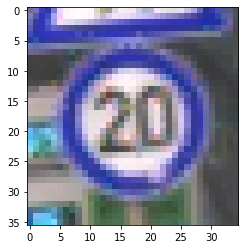

In [53]:
plt.imshow(example_0)

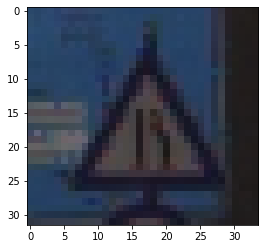

In [54]:
plt.imshow(example_24)

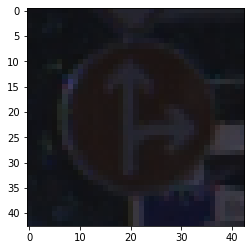

In [55]:
plt.imshow(example_36)